In [1]:
%matplotlib inline
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import joblib

from skimage import  morphology, filters, color, measure
from tensorflow import keras
size = (2,2)

In [2]:
def contrast(img):
    clahe = cv2.createCLAHE(clipLimit=0.2, tileGridSize=(15,15))
    return clahe.apply(img)

def threshold(img):
    thresh = filters.threshold_local(img, 91, offset=18)
    return img > thresh

def load(filename, folder="sudoku"):
    print(filename)
    basedir = os.path.join(os.getcwd(), folder, filename)
    return cv2.imread(basedir, cv2.IMREAD_GRAYSCALE)

def show(img, figsize=(8,8), title=None):
    plt.figure(figsize=figsize)
    
    if(title):
        plt.title(title)
    plt.imshow(img, interpolation="none", cmap="gray")
    plt.show()
    
def outliers(data):
    arr = []
    threshold=3
    mean = np.mean(data)
    std =np.std(data)

    for y in data:
        z_score= (y - mean)/std 
        if np.abs(z_score) <= threshold:
            arr.append(y)
    return arr


def select(x):
    q1, q3= np.percentile(x,[25,75])
    iqr = q3 - q1
    min_area = q1 -(1.5 * iqr) 
    max_area = q3 +(1.5 * iqr)
    
    return[min_area, max_area]


def empty(matrix, boxes):
    x = []
    for i in range(len(matrix)):
        line = ""
        for j in range(len(matrix[i])):
            index = matrix[i][j][0]
            if boxes[index]['filled'] != 1:
                line += "x"
            else:
                line += "-"
        x.append(line)
    return x

def predict(matrix, boxes, modelname):
    model_cnn = keras.models.load_model(modelname)
    x = []
    for i in range(len(matrix)):
        line = ""
        for j in range(len(matrix[i])):
            index = matrix[i][j][0]
            if boxes[index]['filled'] < 1:
                image = ~boxes[index]['clean']
                h,w = image.shape
                w4 = int(w/3.5)
                h4 = int(h/3.5)
                cropped = image[h4:h-h4 ,w4:w-(w4) ]
                resized = cv2.resize((cropped).astype(np.uint8), (28,28))
                pred = model_cnn.predict_proba(resized.reshape(1,28,28,1).astype(np.float16))
                line += str(np.argmax(pred))
            else:
                line += "-"
        x.append(line)
    return x

def compare(x,y, blank=False):
    
    errors = 0
    for i in range(len(x)):
        for j in range(len(x[0])):
#             print(i,j)

            if(blank):
                if(y[i][j] == "-" and x[i][j] != "-" or x[i][j] == "-" and y[i][j] != "-"):
                    errors+=1
            else:
                if(y[i][j] != x[i][j]):
                    errors+=1
                    print(f"Esperado {y[i][j]} (y) e recebeu {x[i][j]} (x) na posição ({i}, {j})")
    return 1- (errors/(len(x)*len(x[0])))

def digits(opening, areas, region):
    mask = np.zeros_like(opening)
    min_area, max_area = select(areas)
    boxes = {}
    count = 0
    for obj in region:
        area = obj["area"]

        if (area > min_area and area < max_area):
            bbox = obj.bbox
            mask[bbox[0]:bbox[2],bbox[1]:bbox[3]]|= (obj.filled_image)
            boxes[obj.label] = {}
            boxes[obj.label]['mask'] = (opening[bbox[0]:bbox[2],bbox[1]:bbox[3]] & (obj.filled_image))
            boxes[obj.label]['clean'] =  (boxes[obj.label]['mask'] | (~obj.filled_image))

            # Porcentagem de pixeis preenchidos em cada região
            boxes[obj.label]['filled'] = obj.area/obj.filled_area
            boxes[obj.label]['bbox'] = list(bbox)
            count +=1

    return boxes, mask

def sort(x):
    return sorted(x, key = lambda x: x[2])


In [3]:
sudoku = os.path.join(os.getcwd(), 'sudoku')
files = [os.path.splitext(x) for x in os.listdir(sudoku)]

davidf2-5.png


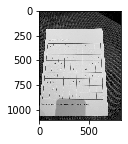

In [4]:
filename = 'davidf2-5'
basedir = os.path.join(os.getcwd(), 'sudoku')
img = load(filename+'.png')
show(img, figsize=size)

<Figure size 144x144 with 0 Axes>

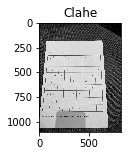

In [5]:
img_clahe = contrast(img)
plt.figure(figsize=size)
show(img_clahe, figsize=size, title="Clahe")

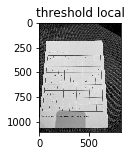

In [6]:
clean = threshold(img_clahe)
show(img_clahe, figsize=size, title='threshold local')

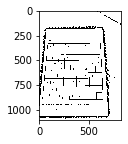

In [7]:
opening = ~morphology.remove_small_objects(~clean, min_size=30)
show(opening, figsize=size)

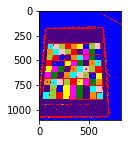

In [8]:
label = morphology.label(opening, connectivity=2)
show(color.label2rgb(label), figsize=size)

In [9]:
region = measure.regionprops(label)

In [10]:
areas = []
for obj in region:
    area = obj["area"]
    if area > 20 :
        areas.append(area)
    

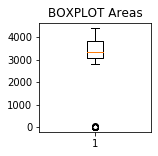

In [11]:
fig, ax = plt.subplots(figsize=size)
ax.set_title('BOXPLOT Areas')
ax.boxplot(outliers(areas))
plt.show()

In [12]:

        #         imagem |= (label == obj.label)
boxes, mask = digits(opening, areas, region)   

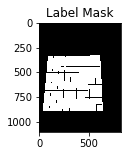

In [13]:
show(mask, figsize=size, title='Label Mask')

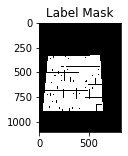

In [14]:
show(mask& opening, figsize=size, title='Label Mask')

In [15]:
points = [[x] + boxes[x]['bbox'] + [boxes[x]['filled']] for x in boxes.keys()]
points = sorted(points, key = lambda y: y[1])
chunks = np.asarray(points).reshape(9,9,6)

def sort(x):
    return sorted(x, key = lambda x: x[2])

matrixM = map(sort, chunks)
matrix = list(matrixM)

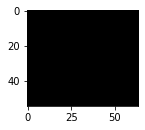

In [16]:
index = matrix[2][1][0].astype(int)
plt.figure(figsize=(2,2))
plt.imshow(~boxes[index]['clean'], interpolation="none", cmap="gray", vmin=0, vmax=1)
plt.show()

In [17]:
resized = cv2.resize((~boxes[index]['clean']).astype(np.uint8), (28,28))

In [18]:
model_cnn = keras.models.load_model('mnist-model.h5')

In [19]:
x = predict(matrix, boxes, 'mnist-model.h5')

In [20]:
with open(os.path.join(basedir,f'{filename}.txt')) as file:
    y = file.read().split()

In [21]:
compare(x,y)

Esperado 5 (y) e recebeu 3 (x) na posição (2, 8)
Esperado 1 (y) e recebeu 8 (x) na posição (3, 0)
Esperado 2 (y) e recebeu 3 (x) na posição (3, 8)
Esperado 6 (y) e recebeu 8 (x) na posição (4, 6)
Esperado 1 (y) e recebeu 0 (x) na posição (5, 7)
Esperado 2 (y) e recebeu 3 (x) na posição (6, 1)


0.9259259259259259

In [22]:
x

['5--82-3--',
 '-------7-',
 '---43--23',
 '869----33',
 '--5-1-8--',
 '38----507',
 '83--96---',
 '-5-------',
 '--1-52--3']

In [23]:
y

['5--82-3--',
 '-------7-',
 '---43--25',
 '169----32',
 '--5-1-6--',
 '38----517',
 '82--96---',
 '-5-------',
 '--1-52--3']

In [24]:
!code .